In [ ]:
from tensorflow import keras
# from models.ts_cnn import MULTI_CLASS_TS_RNN as ts_cnn # v5 /rnn
from models.ts_cnn import ATTENTION_MODEL_TS_CNN as ts_cnn # v4_attention
# from models.ts_cnn import MULTI_CLASS_TS_CNN as ts_cnn # v3
import numpy as np
from sklearn.model_selection import train_test_split
from models.loader import loader
import matplotlib.pyplot as plt
from sklearn import preprocessing
import random
# from utils.normalisation import min_max

In [2]:
# %cd Desktop/pyscript/stf_main/

def augment_data(data, factors=[0.7, 0.9, 1.0, 1.2, 1.5]):
    """
    Augment data by resampling with different factors and maintain original size and sequence.
    """
    augmented = []

    for sample in data:
        for factor in factors:
            # Resample
            original_indices = np.arange(len(sample))
            temp_length = int(len(sample) * factor)
            temp_indices = np.linspace(0, len(sample) - 1, temp_length)
            resampled = np.interp(temp_indices, original_indices, sample)

            # Restore original size
            if factor != 1.0:
                final_indices = np.linspace(0, len(resampled) - 1, len(sample))
                resampled = np.interp(
                    final_indices, np.arange(len(resampled)), resampled
                )

            augmented.append(resampled)

    return np.array(augmented)

In [12]:
# Reading Data
slip_acc = np.loadtxt('data/multiclass_training_data/Slips/incidents_acc.txt')
slip_gyro = np.loadtxt('data/multiclass_training_data/Slips/incidents_gyro.txt')
trip_acc = np.loadtxt('data/multiclass_training_data/Trips/incidents_acc.txt')
trip_gyro = np.loadtxt('data/multiclass_training_data/Trips/incidents_gyro.txt')

slip_acc = augment_data(slip_acc, factors=[0.8, 1.0, 1.2])
slip_gyro = augment_data(slip_gyro, factors=[0.8, 1.0, 1.2])
trip_acc = augment_data(trip_acc, factors=[0.8, 1.0, 1.2])
trip_gyro = augment_data(trip_gyro, factors=[0.8, 1.0, 1.2])


no_incident_acc = np.loadtxt('data/multiclass_training_data/Base Case Walking/no_incidents_acc.txt')
no_incident_gyro = np.loadtxt('data/multiclass_training_data/Base Case Walking/no_incidents_gyro.txt')

# no_incident_acc = augment_data(no_incident_acc, factors=[0.7, 0.8, 1.0, 1.2, 1.5])
# no_incident_gyro = augment_data(no_incident_gyro, factors=[0.7, 0.8, 1.0, 1.2, 1.5])

chaotic_acc = np.loadtxt("data/multiclass_training_data/JW Data/cwalking_acc.txt")
chaotic_gyro = np.loadtxt("data/multiclass_training_data/JW Data/cwalking_gyro.txt")

# chaotic_acc = augment_data(chaotic_acc, factors=[0.8, 1.0, 1.2])
# chaotic_gyro = augment_data(chaotic_gyro, factors=[0.8, 1.0, 1.2])

x_noise_acc = np.random.rand(400, 200)
x_noise_gyro = np.random.rand(400, 200)


In [13]:

# Stacking
x_slip = np.stack([slip_acc, slip_gyro], axis=1)
x_trip = np.stack([trip_acc, trip_gyro], axis=1)
x_no_incident = np.stack([no_incident_acc, no_incident_gyro], axis=1)
x_chaotic_walking = np.stack([chaotic_acc, chaotic_gyro], axis=1)
x_noise = np.stack([x_noise_acc, x_noise_gyro], axis=1)

x_negative = np.concatenate([x_noise, x_no_incident, x_chaotic_walking])
x_incidents = np.concatenate([x_slip, x_trip])

x = np.concatenate([x_negative, x_slip, x_trip], axis=0)

# Labels
y_slip = np.ones(x_slip.shape[0]).astype(int)
y_trip = np.ones(x_trip.shape[0]) + 1
y_trip = y_trip.astype(int)
y_negative = np.zeros(x_negative.shape[0]).astype(int)
y_all = np.concatenate([y_negative, y_slip, y_trip])
y = keras.utils.to_categorical(y_all)

print(f'x slip: {x_slip.shape}')
print(f'x trip: {x_trip.shape}')
print(f'x no incident: {x_negative.shape}')
print('____________________________________')

#Check for nans
print(f'x: {x.shape}')
print(f'nans: {np.any(np.isnan(x))}')
print(f'y: {y.shape}')

x slip: (762, 2, 200)
x trip: (732, 2, 200)
x no incident: (1110, 2, 200)
____________________________________
x: (2604, 2, 200)
nans: False
y: (2604, 3)


In [14]:
def min_max(data):
    """
    Normalize the data to the range [0, 1].
    """
    min_val = np.min(data)
    max_val = np.max(data)
    if max_val - min_val == 0:
        return np.zeros_like(data)  # Handle constant arrays
    return (data - min_val) / (max_val - min_val)


# Assuming x is your 3D array with shape (samples, channels, features)
x_normalized = np.zeros_like(x)

for sample in range(x.shape[0]):  # iterate over samples
    for channel in range(x.shape[1]):  # iterate over channels (acc and gyro)
        x_normalized[sample, channel, :] = min_max(x[sample, channel, :])



In [15]:
print("Original data shape:", x.shape)
print("Normalized data shape:", x_normalized.shape)
print("Original data range:", np.min(x), "-", np.max(x))
print("Normalized data range:", np.min(x_normalized), "-", np.max(x_normalized))

# Check if each sample is indeed normalized to [0, 1]
for i in range(min(5, x.shape[0])):  # Check first 5 samples
    print(f"Sample {i} range:", np.min(x_normalized[i]), "-", np.max(x_normalized[i]))

Original data shape: (2604, 2, 200)
Normalized data shape: (2604, 2, 200)
Original data range: -9.81 - 3304.5274086629215
Normalized data range: 0.0 - 1.0
Sample 0 range: 0.0 - 1.0
Sample 1 range: 0.0 - 1.0
Sample 2 range: 0.0 - 1.0
Sample 3 range: 0.0 - 1.0
Sample 4 range: 0.0 - 1.0


In [16]:
# Shuffle data
idx = np.random.permutation(len(x_normalized))
x = x_normalized[idx]
y = y[idx]
y_all = y_all[idx]

In [33]:
model = ts_cnn()

# Create learning rate schedule for smoother decay
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-4,  # Lower initial rate
    decay_steps=1000,
    decay_rate=0.95,
    staircase=True,
)

# Configure optimizer with more conservative parameters
optimizer = keras.optimizers.Adam(
    learning_rate=lr_schedule,
    beta_1=0.95,  # Increased momentum retention
    beta_2=0.999,
    epsilon=1e-07,
    clipnorm=1.0,  # Add gradient clipping
)

# Update model compilation
model.compile(
    optimizer=optimizer, loss=["CategoricalCrossentropy"], metrics=["accuracy"]
)


In [34]:
epochs = 300
batch_size = 64
model.fit(
    [x[:,0], x[:,1]],
    y,
    batch_size=batch_size,
    epochs=epochs,
    # callbacks=callbacks,
    validation_split=0.4,
    verbose=2,
)
history = model.history.history

Epoch 1/300
25/25 - 1s - loss: 0.7753 - accuracy: 0.5832 - val_loss: 0.9607 - val_accuracy: 0.5557 - 1s/epoch - 48ms/step
Epoch 2/300
25/25 - 0s - loss: 0.6807 - accuracy: 0.6735 - val_loss: 1.0348 - val_accuracy: 0.4559 - 184ms/epoch - 7ms/step
Epoch 3/300
25/25 - 0s - loss: 0.6557 - accuracy: 0.6722 - val_loss: 1.2004 - val_accuracy: 0.2985 - 178ms/epoch - 7ms/step
Epoch 4/300
25/25 - 0s - loss: 0.6169 - accuracy: 0.7183 - val_loss: 1.4108 - val_accuracy: 0.2908 - 196ms/epoch - 8ms/step
Epoch 5/300
25/25 - 0s - loss: 0.5932 - accuracy: 0.7010 - val_loss: 1.6270 - val_accuracy: 0.2908 - 193ms/epoch - 8ms/step
Epoch 6/300
25/25 - 0s - loss: 0.5878 - accuracy: 0.7260 - val_loss: 1.8494 - val_accuracy: 0.2917 - 182ms/epoch - 7ms/step
Epoch 7/300
25/25 - 0s - loss: 0.5525 - accuracy: 0.7478 - val_loss: 2.0162 - val_accuracy: 0.2917 - 183ms/epoch - 7ms/step
Epoch 8/300
25/25 - 0s - loss: 0.5240 - accuracy: 0.7663 - val_loss: 2.1157 - val_accuracy: 0.2917 - 194ms/epoch - 8ms/step
Epoch 9/30

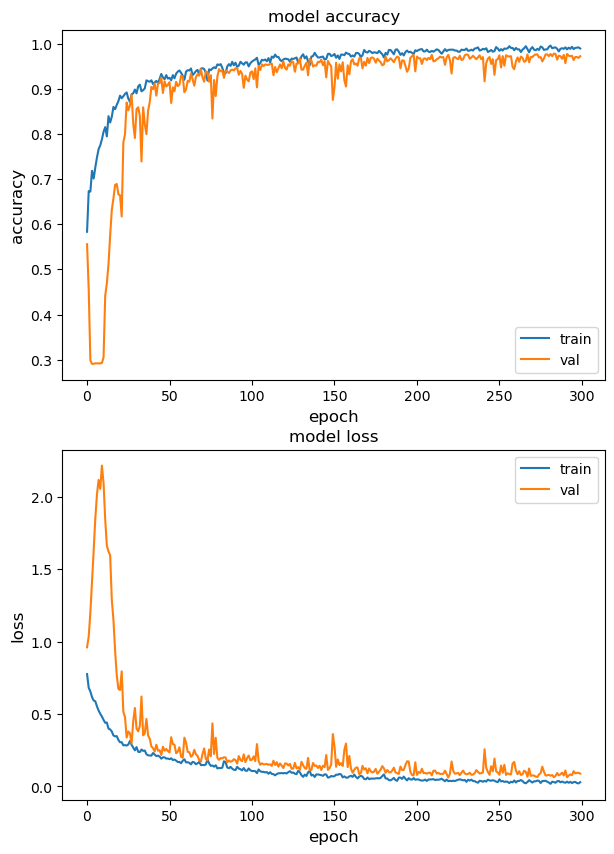

In [35]:
plt.figure(figsize=(7, 10))
metric = "accuracy"
plt.subplot(2, 1, 1)
plt.plot(history[metric])
plt.plot(history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")

plt.subplot(2, 1, 2)
metric = "loss"
plt.plot(history[metric])
plt.plot(history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()

In [36]:
# Saving current model
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("model_v3c2_attention_20241202.tflite", "wb") as f:
    f.write(tflite_model)


# save model weights
model.save_weights("model_v2rnn_20241202.h5")

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpdo9xac3e\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpdo9xac3e\assets


In [37]:
# Model Loader:

model = ts_cnn()
model.load_weights("model_v2rnn_20241202.h5")

In [38]:
idx = np.random.permutation(len(x))
x = x[idx]
y = y[idx]

print(f'First 5 samples: {y[:5]}') # see a couple of examples
np.argmax(y, axis=1)[:5]

# find how many positive and negative samples are in the dataset
print(f'positive: {np.sum(np.argmax(y, axis=1) == 0)}')
print(f'negative: {np.sum(np.argmax(y, axis=1) == 1)}')

# y_val = np.reshape(y, (len(y),))
y_val = y.argmax(axis=1)
y_pred = np.argmax(model.predict([x[:,0], x[:,1]]), axis=1)

# find how many positive and negative samples are in the predicted dataset
print(f'prediction_negative: {np.sum(y_pred == 0)}')
print(f'prediction_slip: {np.sum(y_pred == 1)}')
print(f'prediction_trip: {np.sum(y_pred == 2)}')

First 5 samples: [[0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
positive: 1110
negative: 762
82/82 [==============================] - 0s 2ms/step
prediction_negative: 1101
prediction_slip: 778
prediction_trip: 725


In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_val, y_pred, labels=[0,1,2])

In [40]:
result

array([[1101,    7,    2],
       [   0,  756,    6],
       [   0,   15,  717]], dtype=int64)

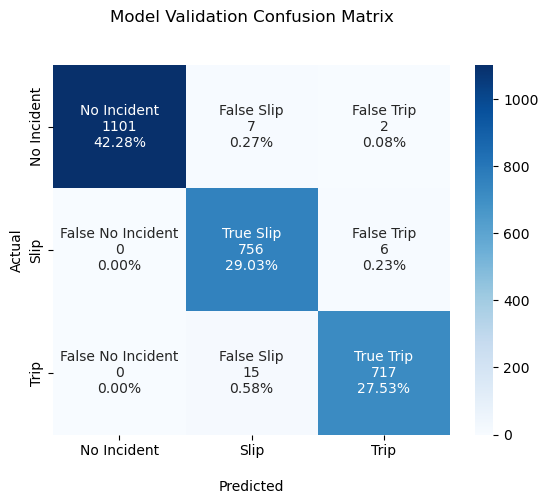

In [41]:
# Matrix with labels
group_names = ['No Incident','False Slip','False Trip',
                'False No Incident', 'True Slip', 'False Trip',
                'False No Incident', 'False Slip', 'True Trip']
group_counts = ["{0:0.0f}".format(value) for value in result.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in result.flatten()/np.sum(result)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)

ax = sns.heatmap(result, annot=labels, fmt='', cmap='Blues')
ax.set_title('Model Validation Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['No Incident','Slip', 'Trip'])
ax.yaxis.set_ticklabels(['No Incident','Slip', 'Trip'])

## Display the visualization of the Confusion Matrix.
plt.show()

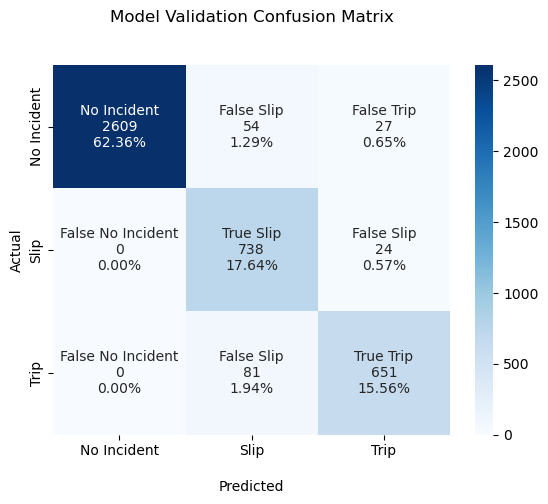

In [37]:
# Matrix with labels
group_names = [
    "No Incident",
    "False Slip",
    "False Trip",
    "False No Incident",
    "True Slip",
    "False Slip",
    "False No Incident",
    "False Slip",
    "True Trip",
]
group_counts = ["{0:0.0f}".format(value) for value in result.flatten()]
group_percentages = [
    "{0:.2%}".format(value) for value in result.flatten() / np.sum(result)
]

labels = [
    f"{v1}\n{v2}\n{v3}"
    for v1, v2, v3 in zip(group_names, group_counts, group_percentages)
]
labels = np.asarray(labels).reshape(3, 3)

ax = sns.heatmap(result, annot=labels, fmt="", cmap="Blues")
ax.set_title("Model Validation Confusion Matrix\n\n")
ax.set_xlabel("\nPredicted")
ax.set_ylabel("Actual")
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["No Incident", "Slip", "Trip"])
ax.yaxis.set_ticklabels(["No Incident", "Slip", "Trip"])

## Display the visualization of the Confusion Matrix.
plt.show()
